<a href="https://colab.research.google.com/github/bcramp/GenAI/blob/main/HW2/Image_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

Assignment 2

Title: Diffuser Model Hyperparameters Analysis

Name: Brennen Cramp

Date: 2/8/2026

---

# **Image Generation with a Diffuser Model**

---

To set up the experiment, the following libraries will need to be installed:

   1. **diffusers**: This is the core library that contains the Stable **Diffusion Pipeline**.

   2. **transformers**: This provides the **CLIP model**, which acts as the translator between the text prompt and the image generator.

   3. **accelerate**: This helps handle the heavy mathematical lifting on the GPU.
   
   4. Make sure to ask for a GPU to run this norebook:

   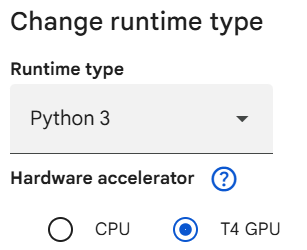



In [1]:
# the needed libraries
!pip install diffusers transformers accelerate


In [2]:
import diffusers
import os

# Disable the problematic progress bar widgets
diffusers.logging.disable_progress_bar()
os.environ["TQDM_DISABLE"] = "1"

# **The Running Environment**

1. We first go to the **Hugging Face Model Hub** and download all the AI models such as the VAE, the **CLIP** tokenizer, etc.

2. **CLIP** stands for **Contrastive Language-Image Pre-training**
   * A model developed by OpenAI that acts as a bridge between **words** and **pictures**.
   
   * **CLIP** was trained by looking at 400 million pairs of images and their captions from the internet to learn how they relate.

   * E.g. If you show it a **photo of a dog** and **the text "a photo of a dog,"** it learns to push those together in its **latent space**.

2. We then move the 4GB+ of model weights from the computer's general memory into the Graphics Card's memory.

3. A CPU might take 5 minutes to make one image but aa CUDA-enabled GPU (NVIDIA) can do it in 2 seconds.

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

# Load the model into memory
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")


# **The Sculptor**

* **Stable Diffusion** creates images by starting with some noise and slowly cleaning it up.

* **Seed**
  * The seed is the number that determines exactly what that static looks like before the AI starts its work. The formula always spits out the exact same pattern of noise.
  * The seed that will be utilized for this assignment will be:
    * **100**

* **Number of Inference Steps**
  * This is the most important parameter here
  * It tells the AI how many times to **chip away** at the noise.
      * **1-10 Steps**: You'll see blurry blobs
      * **20-50 Steps**: You'll see sharper details and textures

* **Prompt**
  * The prompt utlized for this assingment will be:
    * **"A hiker on the top of Mount Fuji overlooking Tokyo during cherry blossom season in Spring."**

* Guidance Scale
  * **Low Scale (1-5)**: The model is more relaxed. It might ignore parts of your prompt but produces smoother, more natural-looking textures.
  * **Medium Scale (7-10)**: The Sweet Spot. This provides a balance between following your instructions and maintaining high image quality.
  * **High Scale (15-30+)**: The model is forced to follow every word. This often leads to oversaturation, extreme contrast, and burnt pixels because the mathematical weights are pushed to their limits.

* **Note**:
  * **CLIP**, the **translator**, uses **Visual Tokens** (14x14 patches).
  * It needs them to **read** an image so it can match it to a caption.
  * **Stable Diffusion**, the **sculptor**, uses a **Latent Space**.

# **Trial A**

* Number of Inference Steps
  * 5

* Guidance Scalar (CFG)
  * 7.5

* Predicted Behavior
  * Under-baked


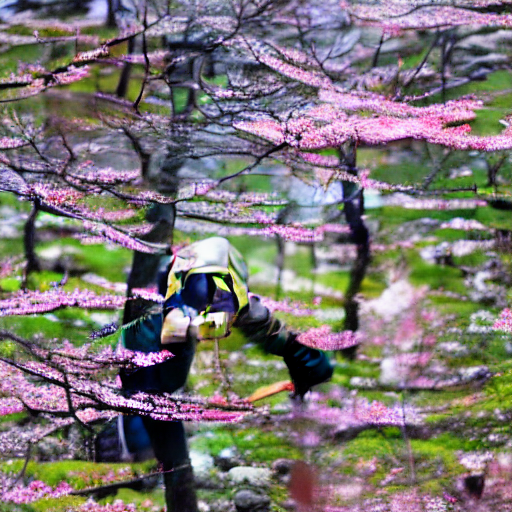

In [9]:
# Create a generator with a fixed seed [a constant seed (control variable) of 100 will be used]
generator = torch.Generator("cuda").manual_seed(100)

# Fixes the GitHub "Invalid Notebook" error
pipe.set_progress_bar_config(disable=True)

# Creates a pipe given a prompt, generator, guidance scalar, and number of steps
# for the AI to chip away at the noise
image = pipe(
    prompt = "A hiker on the top of Mount Fuji overlooking Tokyo during cherry blossom season in Spring.",
    num_inference_steps=5,
    guidance_scale=7.5,
    generator=generator
).images[0]

# Displays the image produced
image

# **Trial B**

* Number of Inference Steps
  * 50

* Guidance Scalar (CFG)
  * 7.5

* Predicted Behavior
  * Optimal


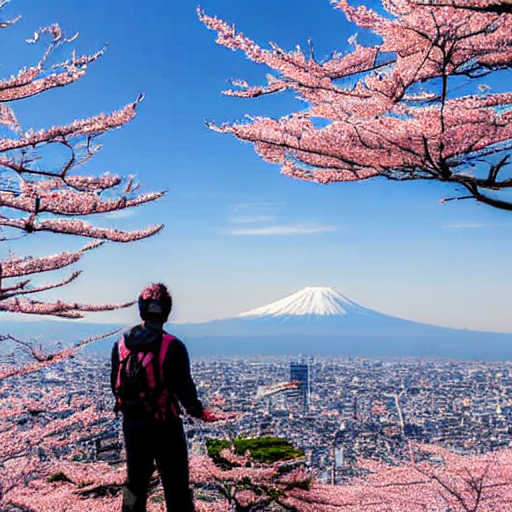

In [10]:
# Create a generator with a fixed seed [a constant seed (control variable) of 100 will be used]
generator = torch.Generator("cuda").manual_seed(100)

# Fixes the GitHub "Invalid Notebook" error
pipe.set_progress_bar_config(disable=True)

# Creates a pipe given a prompt, generator, guidance scalar, and number of steps
# for the AI to chip away at the noise
image = pipe(
    prompt = "A hiker on the top of Mount Fuji overlooking Tokyo during cherry blossom season in Spring.",
    num_inference_steps=50,
    guidance_scale=7.5,
    generator=generator
).images[0]

# Displays the image produced
image

# **Trial C**

* Number of Inference Steps
  * 50

* Guidance Scalar (CFG)
  * 30.0

* Predicted Behavior
  * Over-saturated


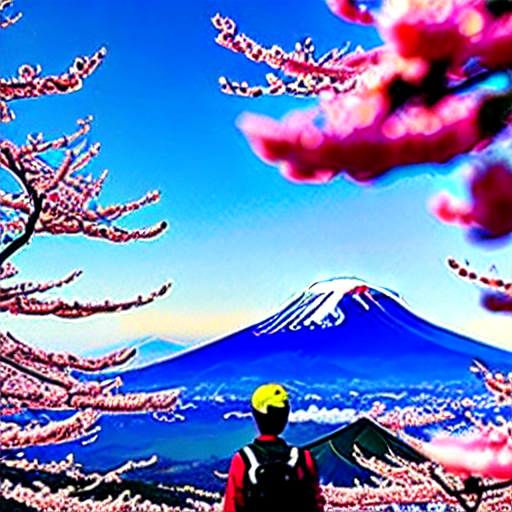

In [11]:
# Create a generator with a fixed seed [a constant seed (control variable) of 100 will be used]
generator = torch.Generator("cuda").manual_seed(100)

# Fixes the GitHub "Invalid Notebook" error
pipe.set_progress_bar_config(disable=True)

# Creates a pipe given a prompt, generator, guidance scalar, and number of steps
# for the AI to chip away at the noise
image = pipe(
    prompt = "A hiker on the top of Mount Fuji overlooking Tokyo during cherry blossom season in Spring.",
    num_inference_steps=50,
    guidance_scale=30.0,
    generator=generator
).images[0]

# Displays the image produced
image

# **Results**

---

| Trial |	Steps	| Guidance (CFG) | Predicted Behavior |	Image Result (Description) | Coherence (1-10) |
| :---: | :---: | :---: | :---: | :---: | :---: |
| **A** | 5 | 7.5 | **Under-baked** | The image looks to have several layers of pictures with the <br/> cherry blossom trees looking very clear and a grainy picture <br/> of Tokyo underneath the trees. The hiker is very contorted and <br/> what looks to be their face isolated with their body coming <br/> out of the cherry blossom tree. It looks like a very experimental <br/> new-age picture. | 3 |
| **B** | 50 | 7.5 | **Optimal** | The image is generally clear and has distinct features that <br/> shows the cherry blossom trees, a grainy picture of Tokyo <br/> that a decently generated hiker is looking out over, and Mount  <br/> Fuji off in the distance past Tokyo. However, the prompt was <br/> saying that the hiker is on top of Mount Fuji looking out <br/> into Tokyo instead of looking at Tokyo with the mountain <br/> in the background. The picture is handily the best out of the trials. | 7 |
| **C** | 50 | 30.0 | **Over-saturated** | The image looks like a deep-fried oil painting with saturated <br/> colors where it has an over-the-shoulder camera <br/> position behind the hiker and the cherry blossoms being <br/> blurry with the flowers on them being clumped together and <br/> very blotchy. The mountain looks to be in the image three times <br/> and the snow on top of the main mountain looking very "stringy". <br/> It also seems that Tokyo is not in the picture or is extremely <br/> grainy right underneath the main mountain. | 5 |

---

The following scale was used to grade the model's coherence:

  * 9-10 (Perfect): Sharp code text, distinct terminal geometry, and realistic neon lighting.

  * 7-8 (High): Recognizable subjects, but with slight muddy textures or minor artifacts.

  * 5-6 (Fair): You can follow the vibe, but it looks more like an oil painting than a sharp photo.

  * 3-4 (Poor): Features are melting.

  * 1-2 (Incoherent): Mostly noise or a deep-fried mess of colors.

# **Analysis**

---

Answer the following questions based on your specific results:

1. Compare **Trial A** to **Trial B**. Why does 5 steps result in a blurry **ghost** of an image?

2. In **Trial C**, look at the colors. Did they become more realistic, or did they start to become too bright/dark? Explain why.

3. Does doubling the steps double the time it takes to generate the image? Why or why not?

# **Extra Credit**

---

* In the standard Diffusion process, we provide a Positive Prompt to tell the model what to build.
* However, a crucial tool for AI developers is the Negative Prompt. This tells the model to move the latent vector away from certain concepts during each denoising step.
* Use the exact same Seed, Steps (50), and Guidance Scale (7.5) from Trial B.
* To implement this part, you will use the negative_prompt argument within your existing pipe() call.

---

* Explain the observed results.
* Explain why a Negative Prompt can be more powerful than just changing the positive prompt.
* Does the image still look like a hacker terminal without any text or the color green? Rate the result on a scale of 1-10 based on how well it kept the "cyberpunk" theme despite the restrictions.

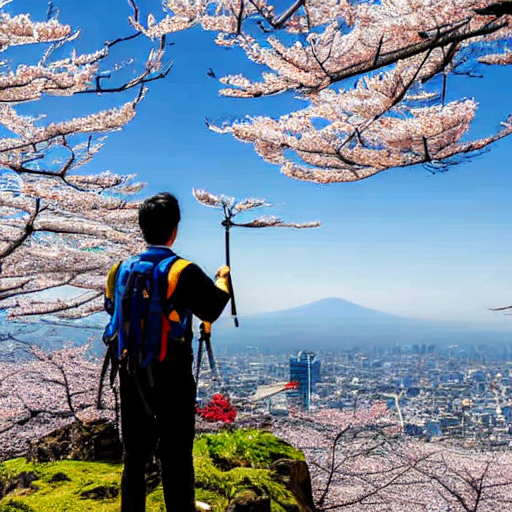

In [13]:
# Create a generator with a fixed seed [a constant seed (control variable) of 100 will be used]
generator = torch.Generator("cuda").manual_seed(100)

# Fixes the GitHub "Invalid Notebook" error
pipe.set_progress_bar_config(disable=True)

# Creates a pipe given a prompt, negative prompt, generator, guidance scalar, and number of steps
# for the AI to chip away at the noise
image = pipe(
    prompt = "A hiker on the top of Mount Fuji overlooking Tokyo during cherry blossom season in Spring.",
    negative_prompt = "pink, mountain, city, beautiful, chilly",
    num_inference_steps=50,
    guidance_scale=7.5,
    generator=generator
).images[0]

# Displays the image produced
display(image)